## Introduction

- Linear regression analysis is often the starting point of an empirical investigation.
- This lecture is limited to basic regression analysis on cross-section data of a continuous dependent variable.

## Data and data summary

- We present ways to summarize and gain some understanding of the data, a necessary step before any regression analysis.
- We analyze medical expenitures of individuals 65 years and older who qualify for health care under the U.S. Medicare program.
- Given the dataset for analysis, we begin by using the `describe` method to list various features of the variables to be used in the linear regression.

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

data=pd.read_stata('data/mus03data.dta')

In [47]:
vl=['totexp','ltotexp','totexp','posexp','suppins','phylim','actlim','totchr','age','female','income']
data[vl].describe()

,totexp,ltotexp,totexp,posexp,suppins,phylim,actlim,totchr,age,female,income
count,3064.000000,2955.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000
mean,7030.889360,8.059871,7030.889360,0.964426,0.581266,0.425587,0.283616,1.754243,74.171671,0.579634,22.474722
std,11852.751889,1.367593,11852.751889,0.185257,0.493434,0.494512,0.450826,1.307197,6.372938,0.493698,22.534910
min,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,0.000000,-1.000000
25%,1272.500000,7.267525,1272.500000,1.000000,0.000000,0.000000,0.000000,1.000000,69.000000,0.000000,9.594000
50%,3134.500000,8.111928,3134.500000,1.000000,1.000000,0.000000,0.000000,2.000000,73.000000,1.000000,15.506000
75%,7142.000000,8.921524,7142.000000,1.000000,1.000000,1.000000,1.000000,3.000000,79.000000,1.000000,27.922750
max,125610.000000,11.740937,125610.000000,1.000000,1.000000,1.000000,1.000000,7.000000,90.000000,1.000000,312.460000


- All variables have the expected range, except that income is negative.
- To see how many observation on income are negative, we use the `value_count` method, restricting attention to nonpositive observations to limit output.

In [48]:
data[data.income<=0].income.value_counts()

 0.0    87
-1.0     1
Name: income, dtype: int64

- Two-way tables can be created by using `crosstab` function.

In [49]:
pd.crosstab(data.female, data.totchr)

totchr,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
female,,,,,,,,
0.0,239,415,323,201,82,23,4,1
1.0,313,466,493,305,140,46,11,2


In [50]:
pd.crosstab(data.female, data.suppins,margins=True)

suppins,0.0,1.0,All
female,,,
0.0,488,800,1288
1.0,795,981,1776
All,1283,1781,3064


- For multiway tables, it is also best to use `crosstab`.

In [51]:
pd.crosstab([data.suppins, data.female], data.totchr)

totchr          0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0
suppins female                                        
0.0     0.0     102  165  121   68   25    6    1    0
        1.0     135  212  233  134   56   22    1    2
1.0     0.0     137  250  202  133   57   17    3    1
        1.0     178  254  260  171   84   24   10    0

- The preceding tabulations will produce voluminous output if one of the variables being tabulated takes on many values.
- Then it is much better to use `groupby` with the previous methods to present tables that give key summary statistics for that variable, such as the mean and standard deviation.

In [52]:
data.groupby(['female']).totchr.describe(percentiles=[])

,count,mean,std,min,50%,max
female,,,,,,
0.0,1288.0,1.659938,1.261175,0.0,1.0,7.0
1.0,1776.0,1.822635,1.335776,0.0,2.0,7.0


In [53]:
data.groupby(['female','suppins']).totchr.agg(['count','mean'])

count      mean
female suppins                 
0.0    0.0        488  1.530738
       1.0        800  1.738750
1.0    0.0        795  1.803774
       1.0        981  1.837920

- It is useful to plot a histogram or a density estimate of the dependent variable.
- Here we use the `DataFrame.plot.kde` method, which provides a kernel estimate of the density.

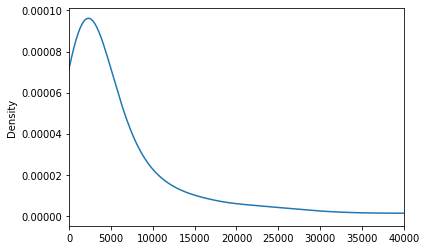

In [54]:
d=data[data.posexp==1].totexp
d.plot.kde(xlim=(0,40000));

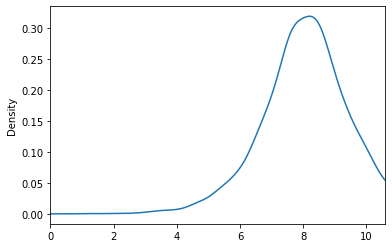

In [55]:
d=data[data.posexp==1].ltotexp
d.plot.kde(xlim=(0,np.log(40000)));

## Basic regression analysis

- We use `statsmodels` package to do all kinds of regressions.
- For OLS, we use `ols` function to run a regression of the natural logarithm of medical expenditures, `ltotexp`, on `suppins` and several demographic and health-status measures.
- Before regression, it can be useful to investigate pairwise correlations of the depedent variables and key regressor variables by using `corr`.

In [56]:
vl=['ltotexp','suppins','phylim','actlim','totchr','age','female','income']
data[vl].corr()

,ltotexp,suppins,phylim,actlim,totchr,age,female,income
ltotexp,1.000000,0.094113,0.292367,0.288843,0.428338,0.085803,-0.005838,0.002263
suppins,0.094113,1.000000,-0.009327,-0.060350,0.035276,-0.113865,-0.068790,0.201287
phylim,0.292367,-0.009327,1.000000,0.591868,0.346196,0.258793,0.095155,-0.106170
actlim,0.288843,-0.060350,0.591868,1.000000,0.326613,0.238608,0.048842,-0.143322
totchr,0.428338,0.035276,0.346196,0.326613,1.000000,0.100650,0.061447,-0.065237
age,0.085803,-0.113865,0.258793,0.238608,0.100650,1.000000,0.081986,-0.152384
female,-0.005838,-0.068790,0.095155,0.048842,0.061447,0.081986,1.000000,-0.128821
income,0.002263,0.201287,-0.106170,-0.143322,-0.065237,-0.152384,-0.128821,1.000000


- The `ols` method performs OLS regression and yields three tables, which includes most information we need.
- For independent cross-section data, the standard approach is to use the `cov_type` parameters for `fit` function, which gives standard errors that are valid even if model errors are heteroskedastic.

In [57]:
f='ltotexp~suppins+phylim+actlim+totchr+age+female+income'
res=smf.ols(formula=f,data=data).fit(cov_type='HC1')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ltotexp   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     127.0
Date:                Fri, 21 Jun 2019   Prob (F-statistic):          1.36e-163
Time:                        10:50:19   Log-Likelihood:                -4733.4
No. Observations:                2955   AIC:                             9483.
Df Residuals:                    2947   BIC:                             9531.
Df Model:                           7                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7037      0.283     23.724      0.000       6.150       7.258
suppins        0.2556      0.047      5.486      0.000       0.164       0.347
phylim         0.3021      0.058      5.235      0.000       0.189       0.415
actlim         0.3560      0.063      5.615      0.000       0.232       0.480
totchr         0.3758      0.019     20.077      0.000       0.339       0.413
age            0.0038      0.004      1.027      0.305      -0.003       0.011
female        -0.0843      0.046     -1.847      0.065      -0.174       0.005
income         0.0025      0.001      2.436      0.015       0.000       0.005
==============================================================================
Omnibus:                       85.373   Durbin-Watson:                   0.451
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.377
Skew:                          -0.253   Prob(JB):                     1.21e-31
Kurtosis:                       3.949   Cond. No.                         979.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

- The `wald_test` methods performs hypothesis tests using the Wald test procedure that uses the estimated model coefficients.
- A common test is one of equality of coefficients.

In [58]:
res.wald_test('phylim=actlim')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.26704764]], p-value=0.6053191494165701, df_denom=1>

- Another common test is one of the joint statistical significance of a subset of the regressors.

In [59]:
res.f_test('phylim=0,actlim=0,totchr=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[272.36086188]]), p=5.051920297189521e-156, df_denom=2947, df_num=3>

- It is very useful to be able to tabulate key results from multiple regressions for both one's own analysis and final report writing.
- We compare the original regression model with a variant that replaces `income` with `educyr`.
- The example uses several of the available options for `summary_col`.

In [60]:
f1='ltotexp~suppins+phylim+actlim+totchr+age+female+educyr'
res1=smf.ols(formula=f1,data=data).fit(cov_type='HC1')

from statsmodels.iolib.summary2 import summary_col

info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}", 'R-squared' : lambda x: f"{x.rsquared:.4f}", 'F stats': lambda x: f"{x.fvalue[0][0]:.4f}"}
summary_col(results=[res,res1], stars = True, model_names=['Reg 1', 'Reg 2'], info_dict=info_dict, regressor_order=['suppins','income','educyr'], drop_omitted=True)

,Reg 1,Reg 2
suppins,0.2556***,0.2063***
,(0.0466),(0.0471)
income,0.0025**,
,(0.0010),
educyr,,0.0480***
,,(0.0070)
No. observations,2955,2955
R-squared,0.2289,0.2406
F stats,126.9723,132.5337


- Suppose we wish to add as regressors to the regression model a set of indicator variables for family size and this set of indicator interacted with income.

In [61]:
f='ltotexp~suppins+phylim+actlim+totchr+age+female+income*C(famsze)'
res2=smf.ols(formula=f,data=data).fit(cov_type='HC1')
res2.summary().tables[1]

C:\Users\bayes\Anaconda3\lib\site-packages\statsmodels\base\model.py:1532: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 25, but rank is 22
  'rank is %d' % (J, J_), ValueWarning)


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,6.7481,0.301,22.452,0.000,6.159,7.337
C(famsze)[T.2.0],0.0759,0.072,1.050,0.294,-0.066,0.218
C(famsze)[T.3.0],-0.2180,0.131,-1.664,0.096,-0.475,0.039
C(famsze)[T.4.0],-0.2928,0.198,-1.476,0.140,-0.682,0.096
C(famsze)[T.5.0],0.3940,0.450,0.875,0.381,-0.488,1.276
C(famsze)[T.6.0],-0.3438,0.452,-0.760,0.447,-1.231,0.543
C(famsze)[T.7.0],-1.1018,0.505,-2.183,0.029,-2.091,-0.113
C(famsze)[T.8.0],0.0021,0.001,3.459,0.001,0.001,0.003
C(famsze)[T.10.0],1.4830,0.298,4.983,0.000,0.900,2.066
C(famsze)[T.13.0],-0.0153,0.001,-26.303,0.000,-0.016,-0.014


## Specification Analysis

- Before interpreting the results, it is useful to subject this regression to some additional scrutiny because a badly misspecification model may lead to erroneous inference.
- In microeconometrics, the most common approach to deciding on the adequacy of a model is a Wald-test approach that fits a richer model and determines whether the data support the need for a richer model.

- Diagnostic plots are used less in microeconometrics than in some other branches of statistics.
- Here we consider various residual plots that can aid in outlier detection, where an outlier is an observation poorly predicted by the model.
- One way to do this is to plot the residuals $\hat{u}_i = y_i - \hat{y}_i$ against the fitted values $\hat{y}_i = x_i'\hat{\beta}$.

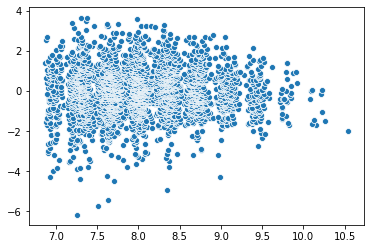

In [62]:
sns.scatterplot(res.fittedvalues,res.resid);

In [63]:
d=pd.concat([data[['totexp','ltotexp']],res.fittedvalues,res.resid],axis=1)
d.columns=['totexp','ltotexp','yhat','uhat']
d[d.uhat<-5]

,totexp,ltotexp,yhat,uhat
0,3.0,1.098612,7.254340,-6.155728
1,6.0,1.791759,7.513357,-5.721598
2,9.0,2.197225,7.631211,-5.433987


- Some observations may have unusual influence in determining parameter estimates and resulting model predictions
- Influential observations can be detected using one of several measures that are large if the residual is large, the leverage measure is large, or both.

- A commonly used measure is $\text{dfits}_i$, which can be shown to equal the difference between predictions of $y_i$ with and without the ith observation in the OLS regression.
- A rule of thumb is that observations with $|\text{dfits}|>2\sqrt{k/N}$ may be worthy of further investigation, though for large datasets this rule can suggest that many observations are influential.

In [64]:
f='ltotexp~suppins+phylim+actlim+totchr+age+female+income'
res=smf.ols(formula=f,data=data).fit()
r=res.get_influence()
dfits,threshold=r.dffits
threshold

0.10406297715753676

In [65]:
dfits=pd.Series(dfits,name='dfits')
dfits.describe()

count    2955.000000
mean       -0.000449
std         0.052850
min        -0.421218
25%        -0.030351
50%         0.000247
75%         0.031175
max         0.220728
Name: dfits, dtype: float64

In [66]:
d=pd.concat([dfits,d],axis=1)
d[abs(d.dfits)>2*threshold]

,dfits,totexp,ltotexp,yhat,uhat
0,-0.231918,3.0,1.098612,7.254340,-6.155728
1,-0.300299,6.0,1.791759,7.513357,-5.721598
2,-0.276527,9.0,2.197225,7.631211,-5.433987
9,-0.217006,30.0,3.401197,8.348724,-4.947527
41,-0.261232,103.0,4.634729,7.579820,-2.945091
43,-0.421218,110.0,4.700480,8.993904,-4.293423
107,-0.232628,228.0,5.429346,7.971406,-2.542060
113,-0.244763,239.0,5.476463,7.946240,-2.469776
136,-0.217734,283.0,5.645447,7.929720,-2.284273
210,-0.211344,415.0,6.028278,8.028338,-2.000060


- The most common specification test is to include additional regressors and test whether they are statistically significant by using a Wald test of the null hypothesis that the coefficient is zero.
- Here we consider a test specific to the current example. We want to decide whether a regression model for medical expenditures is better in logs than in levels.

In [67]:
from scipy.stats import boxcox
t,theta,ci=boxcox(data.loc[data.totexp>0,'totexp'],alpha=0.05)
print(theta) # theta = 0 for log model
print(ci)

0.07740018851220104
(0.05746109979663132, 0.09750280496234609)


- The linear regression model specifies that the conditional mean of the depentdent variable equals $x'_i\beta$
- A common approach is to add powers of $\hat{y}_i=x'_i\hat{\beta}$, the fitted value of the dependent variable, as regressors and a test for the statistical significance of the powers.

In [68]:
from statsmodels.stats.outliers_influence import reset_ramsey
f='ltotexp~suppins+phylim+actlim+totchr+age+female+income'
res1=smf.ols(formula=f,data=data).fit(cov_type='HC1')
reset_ramsey(res1,4)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[9.03663791]]), p=5.9146084834478285e-06, df_denom=2944, df_num=3>

- An alternative, simpler test is provided by the link test. 
- This regresses $y$ on $\hat{y}$ and $\hat{y}^2$, where now the original model regressors $x$ are omitted, and it tests whether the coefficient of $\hat{y}^2$ is zero.

In [69]:
df=pd.DataFrame()
df['ltotexp']=res.model.endog
df['yhat']=res.predict()
f='ltotexp~yhat+I(yhat**2)'
res2=smf.ols(formula=f,data=df).fit()
res2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-14.0113,2.780,-5.040,0.000,-19.462,-8.560
yhat,4.4292,0.678,6.533,0.000,3.100,5.759
I(yhat ** 2),-0.2084,0.041,-5.064,0.000,-0.289,-0.128


- There may be interest in formally testing whether heteroskedasticity is present.
- The simplest version is the Breusch-Pagan Lagrange multiplier test, which is equal to N times the uncentered explained sum of squares from the regression of the squared residuals on an intercept and z.
- Several choices of the components of z are possible.
- Standard choices are to use the OLS fitted value $\hat{y}$, or to use all the regressors so z = x.

In [88]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
name = ['Lagrange multiplier statistic', 'p-value']
test = sms.het_breuschpagan(res.resid, np.column_stack([np.ones(len(res.resid)),res.predict()]))
lzip(name, test)

[('Lagrange multiplier statistic', 32.86920466895129),
 ('p-value', 9.857244984434207e-09)]

In [90]:
test = sms.het_breuschpagan(res.resid, res.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 93.12802905335911),
 ('p-value', 2.815060715524527e-17)]

- Tests can have power in more than one direction, so that if a test targeted to a particular type of model misspecification rejects a model, it is not necessary the case that this particular type of model misspecification is the underlying problem.
- To illustrate this example, we use the following simulation exercise.

- The DGP is one with homoskedastic normal errors $$ y_i=exp(1+0.25\times x_i+4\times x_i^2)+u_i $$ where $$x_i\sim U(0,1), \; u_i\sim N(0,1) $$
- We instead fit a model with a misspecified condition mean funciton: $$ y=\beta_0+\beta_1 x+\beta_2 x^2+v $$
- We consider a simulation with a sample size of 50.

In [26]:
from scipy.stats import uniform,norm
x=uniform(0,1).rvs(50)
u=norm(0,1).rvs(50)
y=np.exp(1+0.25*x+4*x**2)+u
d=pd.DataFrame({'y':y,'x':x,'u':u})
res3=smf.ols(formula='y~x+I(x**2)',data=d).fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     162.6
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           7.61e-22
Time:                        10:34:24   Log-Likelihood:                -185.75
No. Observations:                  50   AIC:                             377.5
Df Residuals:                      47   BIC:                             383.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.4888      4.109      4.256      0.000       9.223      25.754
x           -140.4669     21.341     -6.582      0.000    -183.400     -97.534
I(x ** 2)    233.9588     22.227     10.526      0.000     189.243     278.674
==============================================================================
Omnibus:                       50.834   Durbin-Watson:                   1.570
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.215
Skew:                           2.473   Prob(JB):                     3.96e-71
Kurtosis:                      14.452   Cond. No.                         24.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
name = ['Lagrange multiplier statistic', 'p-value']
test = sms.het_breuschpagan(res3.resid, res3.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 13.433571589946109),
 ('p-value', 0.0012104225142752535)]

In [28]:
reset_ramsey(res3,4)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1704.38550884]]), p=1.629714284947637e-45, df_denom=44, df_num=3>

## Prediction

- The most common type of prediction is in-sample, where evaluation is at the observed regressor values for each observation.
- To do this, we use `predict` method after regression.
- We consider prediction based on a linear regression model in levels rather than logs.

In [29]:
data1=data[data.totexp>0]
f='totexp~suppins+phylim+actlim+totchr+age+female+income'
res=smf.ols(formula=f,data=data1).fit(cov_type='HC1')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 totexp   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     40.58
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           7.52e-55
Time:                        10:34:25   Log-Likelihood:                -31763.
No. Observations:                2955   AIC:                         6.354e+04
Df Residuals:                    2947   BIC:                         6.359e+04
Df Model:                           7                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8358.9539   2847.802      2.935      0.003    2777.364    1.39e+04
suppins      724.8632    427.305      1.696      0.090    -112.638    1562.365
phylim      2389.0186    544.349      4.389      0.000    1322.114    3455.924
actlim      3900.4908    705.224      5.531      0.000    2518.276    5282.705
totchr      1844.3769    186.894      9.869      0.000    1478.072    2210.682
age          -85.3626     37.819     -2.257      0.024    -159.486     -11.239
female     -1383.2898    432.476     -3.199      0.001   -2230.927    -535.653
income         6.4689      8.571      0.755      0.450     -10.329      23.267
==============================================================================
Omnibus:                     2543.516   Durbin-Watson:                   0.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75622.335
Skew:                           4.052   Prob(JB):                         0.00
Kurtosis:                      26.421   Cond. No.                         979.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [30]:
yhat=res.predict()
pd.DataFrame({'totexp':data1.totexp,'predict':yhat}).describe()

,totexp,predict
count,2955.000000,2955.000000
mean,7290.235195,7290.235195
std,11990.841032,4089.624288
min,3.000000,-236.378135
25%,1433.000000,4093.164999
50%,3334.000000,6464.691971
75%,7491.500000,10197.043464
max,125610.000000,22559.002786


- Transforming the dependent variable by taking the natural logarithm complicates prediction.
- It is easy to predict $E(\ln y|x)$, but we are instead interested in $E(y|x)$ because we want to predict the level of medical expenditures rather than the natural logarithm.
- The obvious procedure of predicting $\ln y$ and taking the exponential is wrong because $\exp\{E (\ln y)\} \neq E(y)$.

- The log-linear model $\ln y = x'\beta + u$ implies that $y = \exp(x'\beta)exp(u)$. 
- It follows that $$ E(y_i|x_i) = \exp(x_i'\beta)E\{\exp(u_i)\} $$
- The simplest prediction is $\exp(x_i'\hat{\beta})$, but this is wrong because it ignores the multiple $E\{\exp(u_i)\}$.

- If it is assumed that $u\sim N(0, \sigma^2)$, then it can be shown that $E\{\exp(u_i)\} = \exp(0.5\sigma^2)$, which can be estimated by $\exp(0.5\hat{\sigma}^2)$, where $\hat{\sigma}^2$ is a n unbiased estimator of the log-linear regression model error.
- A weaker assumption is to assume that $u_i$ is independent and identically distributed, in which case we can consistently estimate $E\{\exp(u_i)\}$ by the sample average $N^{-1}\sum_{j=1}^N\exp(\hat{u}_j)$.

In [31]:
f='ltotexp~suppins+phylim+actlim+totchr+age+female+income'
res1=smf.ols(formula=f,data=data1).fit()
lyhat=res1.predict()
yhatwrong=np.exp(lyhat)
yhatnormal=np.exp(lyhat)*np.exp(0.5*res1.mse_resid)
yhatduan=np.exp(lyhat)*np.mean(np.exp(res1.resid))
pd.DataFrame({'totexp':data1.totexp,'yhatwrong':yhatwrong,'yhatnormal':yhatnormal,'yhatduan':yhatduan,'yhatlevels':yhat}).describe()

,totexp,yhatwrong,yhatnormal,yhatduan,yhatlevels
count,2955.000000,2955.000000,2955.000000,2955.000000,2955.000000
mean,7290.235195,4004.452909,8249.927516,8005.522118,7290.235195
std,11990.841032,3303.554757,6805.945260,6604.318063,4089.624288
min,3.000000,959.599322,1976.955412,1918.387798,-236.378135
25%,1433.000000,1982.406211,4084.130321,3963.137320,4093.164999
50%,3334.000000,2961.863251,6101.996375,5921.223774,6464.691971
75%,7491.500000,4730.013141,9744.718305,9456.029495,10197.043464
max,125610.000000,37726.232322,77723.147005,75420.586574,22559.002786


- There are several ways that predictions can be used to simulate the effects of a policy experiment. 
- We consider the effect of a binary treatment, whether a person has supplementary insurance, on medical expenditure. 
- Here we base our predictions on estimates that assume supplementary insurance is exogenous.

- An obvious comparison is to compare the difference in sample means $(\bar{y}_1 - \bar{y}_0)$, where the subscript 1 denotes those with supplementary insurance and the subscript 0 denotes those without supplementary insurance. 
- This measure does not control for individual characteristics. 
- A measure that does control for individual characteristics is the difference in mean predictions $(\bar{\hat{y}}_1 - \bar{\hat{y}}_0)$, where, for example, $\bar{\hat{y}}_1$ denotes the average prediction for those with health insurance.

In [32]:
t=pd.DataFrame({'totexp':data1.totexp,'suppins':data1.suppins,'yhatlevels':yhat,'yhatduan':yhatduan}).groupby('suppins')
t.describe(percentiles=[]).stack()

totexp    yhatlevels      yhatduan
suppins                                                 
0.0     count    1207.000000   1207.000000   1207.000000
        mean     6824.303231   6824.303231   6745.958626
        std     11425.937998   4077.063509   5365.255204
        min         9.000000   -236.378135   1918.387798
        50%      2779.000000   6069.130452   4836.481653
        max    104823.000000  20131.432422  54981.742587
1.0     count    1748.000000   1748.000000   1748.000000
        mean     7611.962815   7611.962815   8875.255033
        std     12358.834637   4068.397367   7212.993184
        min         3.000000    502.923747   2518.538120
        50%      3648.500000   6781.035663   6183.845687
        max    125610.000000  22559.002786  75420.586574

- A third measure is the difference between the mean predictions, one with suppins set to 1 for all observations and one with suppins = 0.
- For the linear model, this is simply the estimated coefficient of suppins, which is \$724.86.

- For the log-linear model, we need to make separate predictions for each individual with suppins set to 1 and with suppins set to 0. 
- For simplicity, we make predictions in levels from the log-linear model assuming normally distributed errors.

In [33]:
df0=data1.copy()
df0['suppins']=0
df1=data1.copy()
df1['suppins']=1
lyhat0=res1.predict(df0)
yhatnormal0=np.exp(lyhat0)*np.exp(0.5*res1.mse_resid)
lyhat1=res1.predict(df1)
yhatnormal1=np.exp(lyhat1)*np.exp(0.5*res1.mse_resid)
treateffect=yhatnormal1-yhatnormal0
pd.DataFrame({'yhatnormal0':yhatnormal0,'yhatnormal1':yhatnormal1,'treateffect':treateffect}).describe(percentiles=[])

,yhatnormal0,yhatnormal1,treateffect
count,2955.000000,2955.000000,2955.000000
mean,7029.453335,9077.072251,2047.618916
std,5664.068827,7313.963053,1649.894226
min,1976.955412,2552.825413,575.870001
50%,4956.093346,6399.760442,1443.667096
max,60190.248554,77723.147005,17532.898451


## Sampling weights

- The analysis to date has presumed simple random sampling, where sample observations have been drawn from the population with equal probability. 
- In practice, however, many microeconometric studies llSe data from surveys that are not representative of the population.

- As explained below, weights should be used for estimation of population means and for postregression prediction and computation of MEs.
- However, in most cases, the regression itself can be fitted without weights, as is the norm in microeconometric.

- To illustrate the use of sampling weights, we create an artificial weighting variable (sampling weights are available for the MEPS data but were not included in the data, extract used in this chapter). 
- We manufacture weights that increase the weight given to those with more chronic problems.

In [34]:
data.loc[:,'swght']=data.totchr**2+0.5
data.swght.describe(percentiles=[])

count    3064.000000
mean        5.285574
std         6.029423
min         0.500000
50%         4.500000
max        49.500000
Name: swght, dtype: float64

- If an estimate of a population mean is desired, then we should clearly weight.

In [35]:
np.average(data.totexp,weights=data.swght)

10670.82547082433

- Although the weighted estimator is easily obtained, for legitimate reasons many microeconometric analyses do not use weighted regression even where sampling weights are available.
- Weighted regression is not needed if we make the stronger assumptions that the DGP is the specified model $y_i = x_i'\beta + u_i$ and sufficient controls are assumed to be added so that the error $E(u_i|x_i) = 0$. 

- This approach, called a control-function approach or a model approach, is the approach usually taken in microeconometric studies that emphasize a causal interpretation of regression. 
- Under the assumption that $E(u_i|x_i) = 0$, the weighted least-squares estimator will be consistent for $\beta$ for any choice of weights including equal weights, and if u, is homoskedastic, the most efficient estimator is the OLS estimator, which uses equal weights.

In [36]:
f='totexp~suppins+phylim+actlim+totchr+age+female+income'
res=smf.wls(formula=f,data=data,weights=data.swght).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 totexp   R-squared:                       0.098
Model:                            WLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     47.26
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           5.16e-64
Time:                        10:34:25   Log-Likelihood:                -34481.
No. Observations:                3064   AIC:                         6.898e+04
Df Residuals:                    3056   BIC:                         6.903e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7336.7580   3202.105      2.291      0.022    1058.261    1.36e+04
suppins      278.1578    526.928      0.528      0.598    -755.012    1311.328
phylim      2484.5203    637.289      3.899      0.000    1234.961    3734.079
actlim      4271.1536    627.107      6.811      0.000    3041.560    5500.748
totchr      1819.9291    202.794      8.974      0.000    1422.302    2217.556
age          -59.3125     41.273     -1.437      0.151    -140.239      21.614
female     -2654.4319    521.910     -5.086      0.000   -3677.763   -1631.101
income         5.0423     13.762      0.366      0.714     -21.941      32.026
==============================================================================
Omnibus:                     3028.885   Durbin-Watson:                   0.500
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           181221.464
Skew:                           4.755   Prob(JB):                         0.00
Kurtosis:                      39.456   Cond. No.                     1.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- The estimated coefficients of all statistically significant variables aside from female are within 10% of those from unweighted regression.
- Big differences between weighted and unweighted regression would indicate that $E(u_i|x_i) \neq 0$ because of model misspecification.

- After regression, unweighted prediction will provide an estimate of the sample-average value of the dependent variable. 
- We may instead want to estimate the population-mean value of the dependent variable. 
- Then sampling weights should be used in forming an average prediction.

In [37]:
yhat=res.predict()
np.mean(yhat)

7135.206175578559

In [38]:
np.average(yhat,weights=data.swght)

10670.825470824346